<a href="https://colab.research.google.com/github/islavathnaveennaik/PhonePe-Pulse-Data-Analysis_project/blob/main/PhonePe_Pulse_Data_Analysis_Extraction%2C_Cleaning%2C_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# PhonePe Pulse Data Analysis: Extraction, Cleaning, and Visualization

This notebook provides a step-by-step guide to extract, clean, and visualize
the PhonePe Pulse data from its GitHub repository. It covers:
1.  Cloning the GitHub repository.
2.  Extracting and consolidating data from multiple JSON files into Pandas DataFrames.
3.  Performing essential data cleaning steps (handling missing values, data types, duplicates, standardization).
4.  Generating various visualizations using Matplotlib, Seaborn, and Plotly, including geo-spatial plots.
5.  Storing the cleaned data in a SQLite database.

**Technologies Used:** Python, Pandas, Matplotlib, Seaborn, Plotly, SQLite.

"""

# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re # Regular expressions for string cleaning

# For interactive plotting and geo-visualization
import plotly.express as px
import plotly.graph_objects as go

# For database interaction
import sqlite3

In [ ]:

# Configure Matplotlib for better display
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")



In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Data Extraction (Cloning GitHub Repository and Reading Data)


In [ ]:
# Clone the PhonePe Pulse GitHub repository

# It will create a 'pulse' directory in your current working directory
if not os.path.exists('pulse'):
    print("Cloning PhonePe Pulse GitHub repository...")
    !git clone https://github.com/PhonePe/pulse.git
    print("Repository cloned successfully.")
else:
    print("PhonePe Pulse repository already exists. Skipping cloning.")

PhonePe Pulse repository already exists. Skipping cloning.


In [ ]:
# Verify cloning by listing contents of the 'pulse' directory
print("\nContents of 'pulse' directory:")
!ls pulse


Contents of 'pulse' directory:
data  LICENSE  README.md


In [ ]:
# Define the base path for the data
base_data_path = 'pulse/data/'

In [ ]:
#  Download and Load Indian States GeoJSON
# This GeoJSON file will be used for accurate plotting of Indian states.
geojson_url = "https://raw.githubusercontent.com/india-in-data/india-states-2019/master/india_states.geojson"
geojson_file_path = "india_states.geojson"

In [ ]:
# --- Function to read and consolidate aggregated transaction data ---
def read_aggregated_transaction_data(base_path):
    """
    Reads and consolidates aggregated transaction data from JSON files.
    """
    data_list = []
    agg_trans_path = os.path.join(base_path, 'aggregated', 'transaction', 'country', 'india', 'state')

    print(f"Reading aggregated transaction data from: {agg_trans_path}")
    # Iterate through each state folder
    for state_folder in os.listdir(agg_trans_path):
        state_path = os.path.join(agg_trans_path, state_folder)
        if os.path.isdir(state_path):
            # Iterate through year folders within each state
            for year_folder in os.listdir(state_path):
                year_path = os.path.join(state_path, year_folder)
                if os.path.isdir(year_path):
                    # Iterate through quarter JSON files within each year
                    for quarter_file in os.listdir(year_path):
                        if quarter_file.endswith('.json'):
                            quarter_path = os.path.join(year_path, quarter_file)
                            try:
                                with open(quarter_path, 'r') as f:
                                    data = json.load(f)
                                    # Extract relevant information
                                    state_name = state_folder.replace('-', ' ').title() # Clean state name
                                    year = int(year_folder)
                                    quarter = int(quarter_file.replace('.json', ''))

                                    for transaction in data.get('data', {}).get('transactionData', []):
                                        # Ensure paymentInstruments exists and has at least one element
                                        if transaction.get('paymentInstruments') and len(transaction['paymentInstruments']) > 0:
                                            payment_instrument = transaction['paymentInstruments'][0]
                                            data_list.append({
                                                'State': state_name,
                                                'Year': year,
                                                'Quarter': quarter,
                                                'Transaction_Type': transaction.get('name'),
                                                'Transaction_Count': payment_instrument.get('count'),
                                                'Transaction_Amount': payment_instrument.get('amount')
                                            })
                            except Exception as e:
                                print(f"Error reading {quarter_path}: {e}")
    return pd.DataFrame(data_list)

In [ ]:
# --- Function to read and consolidate aggregated user data ---
def read_aggregated_user_data(base_path):
    """
    Reads and consolidates aggregated user data from JSON files.
    Corrected to handle the actual structure of the user data JSONs.
    """
    data_list = []
    agg_user_path = os.path.join(base_path, 'aggregated', 'user', 'country', 'india', 'state')

    print(f"Reading aggregated user data from: {agg_user_path}")
    for state_folder in os.listdir(agg_user_path):
        state_path = os.path.join(agg_user_path, state_folder)
        if os.path.isdir(state_path):
            for year_folder in os.listdir(state_path):
                year_path = os.path.join(state_path, year_folder)
                if os.path.isdir(year_path):
                    for quarter_file in os.listdir(year_path):
                        if quarter_file.endswith('.json'):
                            quarter_path = os.path.join(year_path, quarter_file)
                            try:
                                with open(quarter_path, 'r') as f:
                                    data = json.load(f)
                                    state_name = state_folder.replace('-', ' ').title()
                                    year = int(year_folder)
                                    quarter = int(quarter_file.replace('.json', ''))

                                    user_data = data.get('data', {})

                                    # Extract aggregated user data (total registered users and app opens)
                                    # This data is often directly under 'data' with keys like 'registeredUsers' and 'appOpens'
                                    # It's not always in a list under 'aggregated' as initially assumed.
                                    registered_users = user_data.get('registeredUsers')
                                    app_opens = user_data.get('appOpens')

                                    # Extract user by device data if available
                                    if 'userByDevice' in user_data and isinstance(user_data['userByDevice'], list):
                                        for device_data in user_data['userByDevice']:
                                            data_list.append({
                                                'State': state_name,
                                                'Year': year,
                                                'Quarter': quarter,
                                                'Registered_Users': registered_users, # Include total registered users with device data
                                                'App_Opens': app_opens, # Include total app opens with device data
                                                'Brand': device_data.get('brand'),
                                                'Count': device_data.get('count'),
                                                'Percentage': device_data.get('percentage')
                                            })
                                    else:
                                         # If no device data, still add total registered users and app opens
                                         data_list.append({
                                                'State': state_name,
                                                'Year': year,
                                                'Quarter': quarter,
                                                'Registered_Users': registered_users,
                                                'App_Opens': app_opens,
                                                'Brand': None, # No brand info
                                                'Count': None, # No count info
                                                'Percentage': None # No percentage info
                                            })


                            except Exception as e:
                                print(f"Error reading {quarter_path}: {e}")

    # Create DataFrame and handle potential None values in numerical columns before converting to int
    df = pd.DataFrame(data_list)
    if not df.empty:
        for col in ['Registered_Users', 'App_Opens', 'Count']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
        if 'Percentage' in df.columns:
             df['Percentage'] = pd.to_numeric(df['Percentage'], errors='coerce').fillna(0.0)

    return df


In [ ]:
# --- Function to read and consolidate map transaction data ---
def read_map_transaction_data(base_path):
    """
    Reads and consolidates map transaction data from JSON files.
    Corrected path and data extraction logic to handle potential JSON variations.
    """
    data_list = []
    # Corrected path based on repository structure inspection
    map_trans_path = os.path.join(base_path, 'map', 'transaction', 'hover', 'country', 'india', 'state')

    print(f"Reading map transaction data from: {map_trans_path}")
    if not os.path.exists(map_trans_path):
        print(f"Directory not found: {map_trans_path}")
        return pd.DataFrame(data_list) # Return empty DataFrame if path doesn't exist

    for state_folder in os.listdir(map_trans_path):
        state_path = os.path.join(map_trans_path, state_folder)
        if os.path.isdir(state_path):
            for year_folder in os.listdir(state_path):
                year_path = os.path.join(state_path, year_folder)
                if os.path.isdir(year_path):
                    for quarter_file in os.listdir(year_path):
                        if quarter_file.endswith('.json'):
                            quarter_path = os.path.join(year_path, quarter_file)
                            try:
                                with open(quarter_path, 'r') as f:
                                    data = json.load(f)
                                    state_name = state_folder.replace('-', ' ').title()
                                    year = int(year_folder)
                                    quarter = int(quarter_file.replace('.json', ''))

                                    # Check if 'data' key exists and is a dictionary
                                    if isinstance(data.get('data'), dict):
                                        hover_data_list = data['data'].get('hoverDataList', [])
                                        # Ensure hoverDataList is a list
                                        if isinstance(hover_data_list, list):
                                            for district_data in hover_data_list:
                                                # Ensure district_data is a dictionary and 'metric' exists and is a dictionary
                                                if isinstance(district_data, dict) and isinstance(district_data.get('metric'), dict):
                                                     data_list.append({
                                                        'State': state_name,
                                                        'Year': year,
                                                        'Quarter': quarter,
                                                        'District': district_data.get('name'),
                                                        'Transaction_Count': district_data['metric'].get('count'),
                                                        'Transaction_Amount': district_data['metric'].get('amount')
                                                    })
                                                else:
                                                    print(f"Warning: Unexpected structure in hoverDataList item in {quarter_path}: {district_data}")
                                        else:
                                            print(f"Warning: 'hoverDataList' is not a list in {quarter_path}. Data structure: {data.get('data')}")
                                    else:
                                        print(f"Warning: 'data' key missing or not a dictionary in {quarter_path}. Data structure: {data}")


                            except Exception as e:
                                print(f"Error reading {quarter_path}: {e}")

    df = pd.DataFrame(data_list)
    if not df.empty:
        for col in ['Transaction_Count', 'Transaction_Amount']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0) # Keep as float for amount, int for count later if needed

    return df

In [ ]:
# --- Function to read and consolidate top transaction data ---
def read_top_transaction_data(base_path):
    """
    Reads and consolidates top transaction data from JSON files.
    Corrected path and data extraction logic.
    """
    data_list = []
    # Corrected path based on repository structure inspection: 'country' is under 'transaction'
    top_trans_path = os.path.join(base_path, 'top', 'transaction', 'country', 'india', 'state')

    print(f"Reading top transaction data from: {top_trans_path}")
    if not os.path.exists(top_trans_path):
        print(f"Directory not found: {top_trans_path}")
        return pd.DataFrame(data_list) # Return empty DataFrame if path doesn't exist


    for state_folder in os.listdir(top_trans_path):
        state_path = os.path.join(top_trans_path, state_folder)
        if os.path.isdir(state_path):
            for year_folder in os.listdir(state_path):
                year_path = os.path.join(state_path, year_folder)
                if os.path.isdir(year_path):
                    for quarter_file in os.listdir(year_path):
                        if quarter_file.endswith('.json'):
                            quarter_path = os.path.join(year_path, quarter_file)
                            try:
                                with open(quarter_path, 'r') as f:
                                    data = json.load(f)
                                    state_name = state_folder.replace('-', ' ').title()
                                    year = int(year_folder)
                                    quarter = int(quarter_file.replace('.json', ''))

                                    # Top 10 States/Districts/Pincodes by Transaction
                                    # The structure under 'top' data can vary (districts, pincodes, states).
                                    # We'll consolidate all of them with an indicator of the entity type.

                                    for key in ['districts', 'pincodes', 'states']:
                                        # Check if the key exists under 'data' and is a list
                                        if isinstance(data.get('data', {}).get(key), list):
                                            for item in data['data'][key]:
                                                 # Check if 'metric' exists and is a dictionary
                                                if isinstance(item.get('metric'), dict):
                                                    data_list.append({
                                                        'State': state_name,
                                                        'Year': year,
                                                        'Quarter': quarter,
                                                        'Entity_Type': key.capitalize(), # 'Districts', 'Pincodes', 'States'
                                                        'Entity_Name': item.get('entityName'),
                                                        'Transaction_Count': item['metric'].get('count'), # Access count directly
                                                        'Transaction_Amount': item['metric'].get('amount') # Access amount directly
                                                    })
                                                else:
                                                     print(f"Warning: Unexpected structure in {key} item in {quarter_path}: {item}")
                                        elif data.get('data', {}).get(key) is not None:
                                             print(f"Warning: '{key}' key exists but is not a list in {quarter_path}. Data structure: {data.get('data')}")

                            except Exception as e:
                                print(f"Error reading {quarter_path}: {e}")

    df = pd.DataFrame(data_list)
    if not df.empty:
        for col in ['Transaction_Count', 'Transaction_Amount']:
            if col in df.columns:
                 df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0) # Keep as float for amount, int for count later if needed

    return df

# Load data into DataFrames

In [ ]:


df_agg_trans = read_aggregated_transaction_data(base_data_path)
df_agg_user = read_aggregated_user_data(base_data_path)
df_map_trans = read_map_transaction_data(base_data_path)
df_top_trans = read_top_transaction_data(base_data_path) # Example for top transactions

#Aggregated Transactions

In [ ]:
df_agg_trans.head()

,State,Year,Quarter,Transaction_Type,Transaction_Count,Transaction_Amount
0,Uttar Pradesh,2022,4,Merchant payments,439247166,2.967820e+11
1,Uttar Pradesh,2022,4,Peer-to-peer payments,317613698,1.030346e+12
2,Uttar Pradesh,2022,4,Recharge & bill payments,78025017,4.815907e+10
3,Uttar Pradesh,2022,4,Financial Services,418329,4.302129e+08
4,Uttar Pradesh,2022,4,Others,1064861,6.619850e+08


In [ ]:
df_agg_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               5034 non-null   object 
 1   Year                5034 non-null   int64  
 2   Quarter             5034 non-null   int64  
 3   Transaction_Type    5034 non-null   object 
 4   Transaction_Count   5034 non-null   int64  
 5   Transaction_Amount  5034 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 236.1+ KB


In [ ]:
df_agg_trans.isnull().sum()

,0
State,0
Year,0
Quarter,0
Transaction_Type,0
Transaction_Count,0
Transaction_Amount,0


#Aggregated Users


In [ ]:
df_agg_user.head()

,State,Year,Quarter,Registered_Users,App_Opens,Brand,Count,Percentage
0,Uttar Pradesh,2022,4,0,0,None,0,0.0
1,Uttar Pradesh,2022,2,0,0,None,0,0.0
2,Uttar Pradesh,2022,3,0,0,None,0,0.0
3,Uttar Pradesh,2022,1,0,0,None,0,0.0
4,Uttar Pradesh,2020,4,0,0,None,0,0.0


In [ ]:
df_agg_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             1008 non-null   object 
 1   Year              1008 non-null   int64  
 2   Quarter           1008 non-null   int64  
 3   Registered_Users  1008 non-null   int64  
 4   App_Opens         1008 non-null   int64  
 5   Brand             0 non-null      object 
 6   Count             1008 non-null   int64  
 7   Percentage        1008 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 63.1+ KB


In [ ]:
df_agg_user.isnull().sum()

,0
State,0
Year,0
Quarter,0
Registered_Users,0
App_Opens,0
Brand,1008
Count,0
Percentage,0


#Map Transactions

In [ ]:
df_map_trans.head()

""


In [ ]:
df_map_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [ ]:
df_map_trans.isnull().sum()

,0


#Top Transactions


In [ ]:
df_top_trans.head()

,State,Year,Quarter,Entity_Type,Entity_Name,Transaction_Count,Transaction_Amount
0,Uttar Pradesh,2022,4,Districts,lucknow,142292419,2.141390e+11
1,Uttar Pradesh,2022,4,Districts,gautam buddha nagar,90864471,1.041625e+11
2,Uttar Pradesh,2022,4,Districts,ghaziabad,48195051,7.333355e+10
3,Uttar Pradesh,2022,4,Districts,varanasi,38410576,6.167928e+10
4,Uttar Pradesh,2022,4,Districts,kanpur nagar,34663083,5.742358e+10


In [ ]:
df_top_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               18295 non-null  object 
 1   Year                18295 non-null  int64  
 2   Quarter             18295 non-null  int64  
 3   Entity_Type         18295 non-null  object 
 4   Entity_Name         18293 non-null  object 
 5   Transaction_Count   18295 non-null  int64  
 6   Transaction_Amount  18295 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1000.6+ KB


In [ ]:
df_top_trans.isnull().sum()

,0
State,0
Year,0
Quarter,0
Entity_Type,0
Entity_Name,2
Transaction_Count,0
Transaction_Amount,0


#Data Cleaning


**Aggregated Transactions **

In [ ]:
# 1. Handle Missing Values
# For numerical columns, fill NaNs with 0 or mean/median if appropriate
df_agg_trans['Transaction_Count'] = df_agg_trans['Transaction_Count'].fillna(0)
df_agg_trans['Transaction_Amount'] = df_agg_trans['Transaction_Amount'].fillna(0.0)
# For categorical columns, fill with 'Unknown' or mode
df_agg_trans['Transaction_Type'] = df_agg_trans['Transaction_Type'].fillna('Unknown')

In [ ]:
# 2. Correct Data Types
# Ensure numerical columns are of numeric type
df_agg_trans['Transaction_Count'] = pd.to_numeric(df_agg_trans['Transaction_Count'], errors='coerce').astype(int)
df_agg_trans['Transaction_Amount'] = pd.to_numeric(df_agg_trans['Transaction_Amount'], errors='coerce')
df_agg_trans['Year'] = pd.to_numeric(df_agg_trans['Year'], errors='coerce').astype(int)
df_agg_trans['Quarter'] = pd.to_numeric(df_agg_trans['Quarter'], errors='coerce').astype(int)

In [ ]:
# 3. Handle Duplicates
print(f"Aggregated Transactions: Duplicates before dropping: {df_agg_trans.duplicated().sum()}")
df_agg_trans.drop_duplicates(inplace=True)
print(f"Aggregated Transactions: Duplicates after dropping: {df_agg_trans.duplicated().sum()}")

Aggregated Transactions: Duplicates before dropping: 0
Aggregated Transactions: Duplicates after dropping: 0


In [ ]:
# 4. Standardize Text Data (State and Transaction_Type)
# Already handled basic standardization during data loading (title case, replace hyphens)
df_agg_trans['State'] = df_agg_trans['State'].apply(lambda x: re.sub(r'([A-Z])', r' \1', x).strip() if isinstance(x, str) else x) # Add space before capital letters
df_agg_trans['State'] = df_agg_trans['State'].str.replace('Andaman & Nicobar Islands', 'Andaman and Nicobar Islands')
df_agg_trans['State'] = df_agg_trans['State'].str.replace('Dadra & Nagar Haveli & Daman & Diu', 'Dadra and Nagar Haveli and Daman and Diu')
df_agg_trans['State'] = df_agg_trans['State'].str.replace('Jammu & Kashmir', 'Jammu and Kashmir')
df_agg_trans['State'] = df_agg_trans['State'].str.replace('Uttar Pradesh', 'Uttar Pradesh') # No change needed, just example
df_agg_trans['State'] = df_agg_trans['State'].str.replace('Arunachal Pradesh', 'Arunachal Pradesh') # No change needed, just example

df_agg_trans['Transaction_Type'] = df_agg_trans['Transaction_Type'].str.strip().str.title()
print("Aggregated Transactions cleaned.")
print(df_agg_trans.info())
print(df_agg_trans.isnull().sum())

Aggregated Transactions cleaned.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               5034 non-null   object 
 1   Year                5034 non-null   int64  
 2   Quarter             5034 non-null   int64  
 3   Transaction_Type    5034 non-null   object 
 4   Transaction_Count   5034 non-null   int64  
 5   Transaction_Amount  5034 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 236.1+ KB
None
State                 0
Year                  0
Quarter               0
Transaction_Type      0
Transaction_Count     0
Transaction_Amount    0
dtype: int64


**Cleaning Aggregated Users**

In [ ]:
# 1. Handle Missing Values
# Fill numerical NaNs with 0
if 'Registered_Users' in df_agg_user.columns:
    df_agg_user['Registered_Users'] = df_agg_user['Registered_Users'].fillna(0)
if 'App_Opens' in df_agg_user.columns:
    df_agg_user['App_Opens'] = df_agg_user['App_Opens'].fillna(0)
if 'Count' in df_agg_user.columns:
    df_agg_user['Count'] = df_agg_user['Count'].fillna(0)
if 'Percentage' in df_agg_user.columns:
    df_agg_user['Percentage'] = df_agg_user['Percentage'].fillna(0.0)
# Fill categorical NaNs with 'Unknown'
if 'Brand' in df_agg_user.columns:
    df_agg_user['Brand'] = df_agg_user['Brand'].fillna('Unknown')

In [ ]:
# 2. Correct Data Types
if 'Registered_Users' in df_agg_user.columns:
    df_agg_user['Registered_Users'] = pd.to_numeric(df_agg_user['Registered_Users'], errors='coerce').fillna(0).astype(int)
if 'App_Opens' in df_agg_user.columns:
    df_agg_user['App_Opens'] = pd.to_numeric(df_agg_user['App_Opens'], errors='coerce').fillna(0).astype(int)
if 'Count' in df_agg_user.columns:
    df_agg_user['Count'] = pd.to_numeric(df_agg_user['Count'], errors='coerce').fillna(0).astype(int)
if 'Percentage' in df_agg_user.columns:
    df_agg_user['Percentage'] = pd.to_numeric(df_agg_user['Percentage'], errors='coerce').fillna(0.0)

df_agg_user['Year'] = pd.to_numeric(df_agg_user['Year'], errors='coerce').fillna(0).astype(int)
df_agg_user['Quarter'] = pd.to_numeric(df_agg_user['Quarter'], errors='coerce').fillna(0).astype(int)

In [ ]:
# 3. Handle Duplicates
print(f"Aggregated Users: Duplicates before dropping: {df_agg_user.duplicated().sum()}")
df_agg_user.drop_duplicates(inplace=True)
print(f"Aggregated Users: Duplicates after dropping: {df_agg_user.duplicated().sum()}")

Aggregated Users: Duplicates before dropping: 0
Aggregated Users: Duplicates after dropping: 0


In [ ]:
# 4. Standardize Text Data
if 'State' in df_agg_user.columns:
    df_agg_user['State'] = df_agg_user['State'].apply(lambda x: re.sub(r'([A-Z])', r' \1', x).strip() if isinstance(x, str) else x)
    df_agg_user['State'] = df_agg_user['State'].str.replace('Andaman & Nicobar Islands', 'Andaman and Nicobar Islands')
    df_agg_user['State'] = df_agg_user['State'].str.replace('Dadra & Nagar Haveli & Daman & Diu', 'Dadra and Nagar Haveli and Daman and Diu')
    df_agg_user['State'] = df_agg_user['State'].str.replace('Jammu & Kashmir', 'Jammu and Kashmir')
if 'Brand' in df_agg_user.columns:
    df_agg_user['Brand'] = df_agg_user['Brand'].str.strip().str.title()
print("Aggregated Users cleaned.")
print(df_agg_user.info())
print(df_agg_user.isnull().sum())

Aggregated Users cleaned.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             1008 non-null   object 
 1   Year              1008 non-null   int64  
 2   Quarter           1008 non-null   int64  
 3   Registered_Users  1008 non-null   int64  
 4   App_Opens         1008 non-null   int64  
 5   Brand             1008 non-null   object 
 6   Count             1008 non-null   int64  
 7   Percentage        1008 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 63.1+ KB
None
State               0
Year                0
Quarter             0
Registered_Users    0
App_Opens           0
Brand               0
Count               0
Percentage          0
dtype: int64


**Cleaning Map Transactions**

In [ ]:
if 'Transaction_Count' in df_map_trans.columns:
    df_map_trans['Transaction_Count'] = df_map_trans['Transaction_Count'].fillna(0)
if 'Transaction_Amount' in df_map_trans.columns:
    df_map_trans['Transaction_Amount'] = df_map_trans['Transaction_Amount'].fillna(0.0)

In [ ]:
# 2. Correct Data Types
# Check if columns exist before accessing them
if 'Transaction_Count' in df_map_trans.columns:
    df_map_trans['Transaction_Count'] = pd.to_numeric(df_map_trans['Transaction_Count'], errors='coerce').fillna(0).astype(int)
if 'Transaction_Amount' in df_map_trans.columns:
    df_map_trans['Transaction_Amount'] = pd.to_numeric(df_map_trans['Transaction_Amount'], errors='coerce').fillna(0.0)
if 'Year' in df_map_trans.columns:
    df_map_trans['Year'] = pd.to_numeric(df_map_trans['Year'], errors='coerce').fillna(0).astype(int)
if 'Quarter' in df_map_trans.columns:
    df_map_trans['Quarter'] = pd.to_numeric(df_map_trans['Quarter'], errors='coerce').fillna(0).astype(int)

In [ ]:
# 3. Handle Duplicates
df_map_trans.duplicated().sum()
df_map_trans.drop_duplicates(inplace=True)
df_map_trans.duplicated().sum()

np.int64(0)

In [ ]:
# 4. Standardize Text Data
if 'State' in df_map_trans.columns:
    df_map_trans['State'] = df_map_trans['State'].apply(lambda x: re.sub(r'([A-Z])', r' \1', x).strip() if isinstance(x, str) else x)
    df_map_trans['State'] = df_map_trans['State'].str.replace('Andaman & Nicobar Islands', 'Andaman and Nicobar Islands')
    df_map_trans['State'] = df_map_trans['State'].str.replace('Dadra & Nagar Haveli & Daman & Diu', 'Dadra and Nagar Haveli and Daman and Diu')
    df_map_trans['State'] = df_map_trans['State'].str.replace('Jammu & Kashmir', 'Jammu and Kashmir')
if 'District' in df_map_trans.columns:
    df_map_trans['District'] = df_map_trans['District'].str.strip().str.title()
df_map_trans.info()
df_map_trans.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


,0


**Cleaning Top Transactions**

In [ ]:
if 'Transaction_Count' in df_top_trans.columns:
    df_top_trans['Transaction_Count'] = df_top_trans['Transaction_Count'].fillna(0)
if 'Transaction_Amount' in df_top_trans.columns:
    df_top_trans['Transaction_Amount'] = df_top_trans['Transaction_Amount'].fillna(0.0)

In [ ]:
# 2. Correct Data Types
if 'Transaction_Count' in df_top_trans.columns:
    df_top_trans['Transaction_Count'] = pd.to_numeric(df_top_trans['Transaction_Count'], errors='coerce').fillna(0).astype(int)
if 'Transaction_Amount' in df_top_trans.columns:
    df_top_trans['Transaction_Amount'] = pd.to_numeric(df_top_trans['Transaction_Amount'], errors='coerce').fillna(0.0)

df_top_trans['Year'] = pd.to_numeric(df_top_trans['Year'], errors='coerce').fillna(0).astype(int)
df_top_trans['Quarter'] = pd.to_numeric(df_top_trans['Quarter'], errors='coerce').fillna(0).astype(int)

In [ ]:
# 3. Handle Duplicates
df_top_trans.duplicated().sum()
df_top_trans.drop_duplicates(inplace=True)
df_top_trans.duplicated().sum()

np.int64(0)

In [ ]:
# 4. Standardize Text Data
if 'State' in df_top_trans.columns:
    df_top_trans['State'] = df_top_trans['State'].apply(lambda x: re.sub(r'([A-Z])', r' \1', x).strip() if isinstance(x, str) else x)
    df_top_trans['State'] = df_top_trans['State'].str.replace('Andaman & Nicobar Islands', 'Andaman and Nicobar Islands')
    df_top_trans['State'] = df_top_trans['State'].str.replace('Dadra & Nagar Haveli & Daman & Diu', 'Dadra and Nagar Haveli and Daman and Diu')
    df_top_trans['State'] = df_top_trans['State'].str.replace('Jammu & Kashmir', 'Jammu and Kashmir')
if 'Entity_Name' in df_top_trans.columns:
    df_top_trans['Entity_Name'] = df_top_trans['Entity_Name'].str.strip().str.title()
df_top_trans.info()
df_top_trans.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               18295 non-null  object 
 1   Year                18295 non-null  int64  
 2   Quarter             18295 non-null  int64  
 3   Entity_Type         18295 non-null  object 
 4   Entity_Name         18293 non-null  object 
 5   Transaction_Count   18295 non-null  int64  
 6   Transaction_Amount  18295 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1000.6+ KB


,0
State,0
Year,0
Quarter,0
Entity_Type,0
Entity_Name,2
Transaction_Count,0
Transaction_Amount,0


# Data Visualization


** Aggregated Transactions Visualizations**

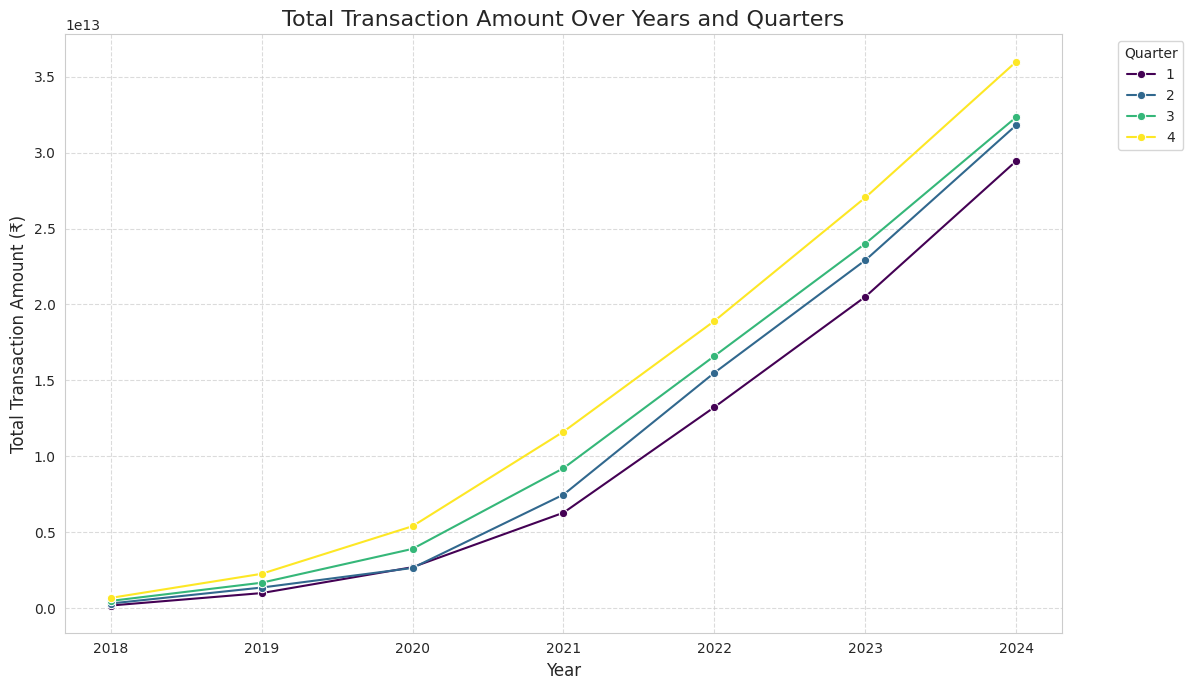

In [ ]:
# Total Transaction Amount Over Years and Quarters
plt.figure(figsize=(12, 7))
agg_trans_time = df_agg_trans.groupby(['Year', 'Quarter'])['Transaction_Amount'].sum().reset_index()
sns.lineplot(data=agg_trans_time, x='Year', y='Transaction_Amount', hue='Quarter', marker='o', palette='viridis')
plt.title('Total Transaction Amount Over Years and Quarters', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Transaction Amount (₹)', fontsize=12)
plt.xticks(agg_trans_time['Year'].unique(), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

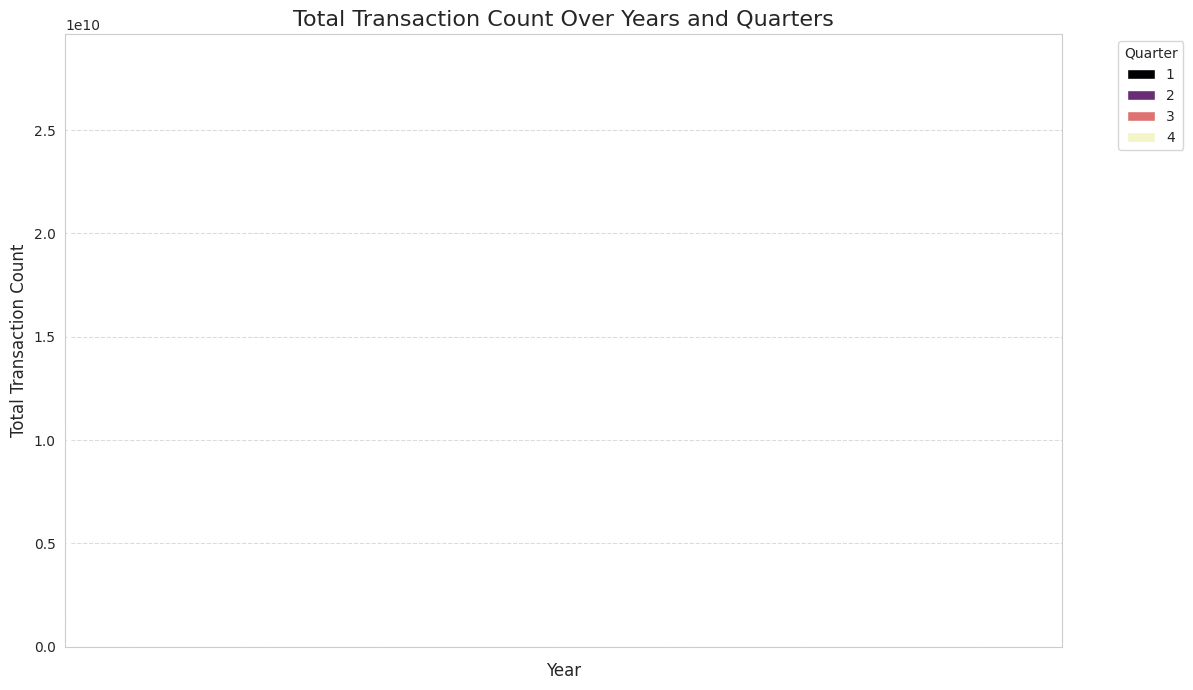

In [ ]:
# Total Transaction Count Over Years and Quarters
plt.figure(figsize=(12, 7))
agg_trans_count_time = df_agg_trans.groupby(['Year', 'Quarter'])['Transaction_Count'].sum().reset_index()
sns.barplot(data=agg_trans_count_time, x='Year', y='Transaction_Count', hue='Quarter', palette='magma')
plt.title('Total Transaction Count Over Years and Quarters', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Transaction Count', fontsize=12)
plt.xticks(agg_trans_count_time['Year'].unique(), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

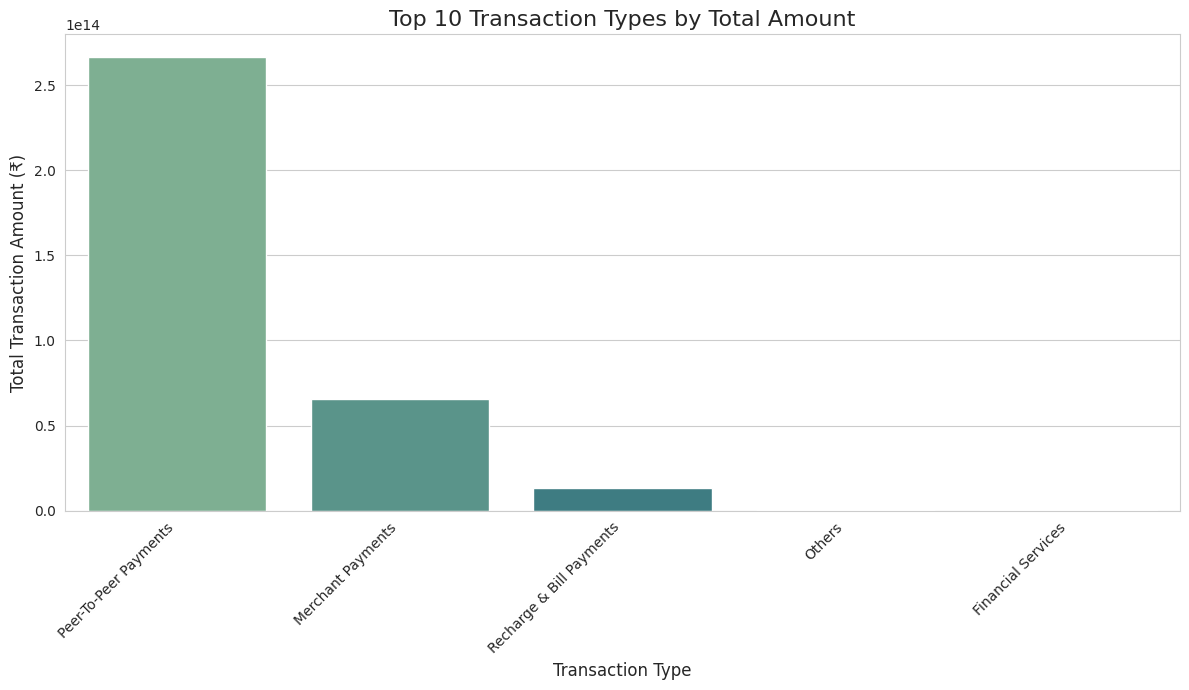

In [ ]:
# Top 10 Transaction Types by Amount
plt.figure(figsize=(12, 7))
top_transaction_types_amount = df_agg_trans.groupby('Transaction_Type')['Transaction_Amount'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_transaction_types_amount.index, y=top_transaction_types_amount.values, palette='crest')
plt.title('Top 10 Transaction Types by Total Amount', fontsize=16)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Total Transaction Amount (₹)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

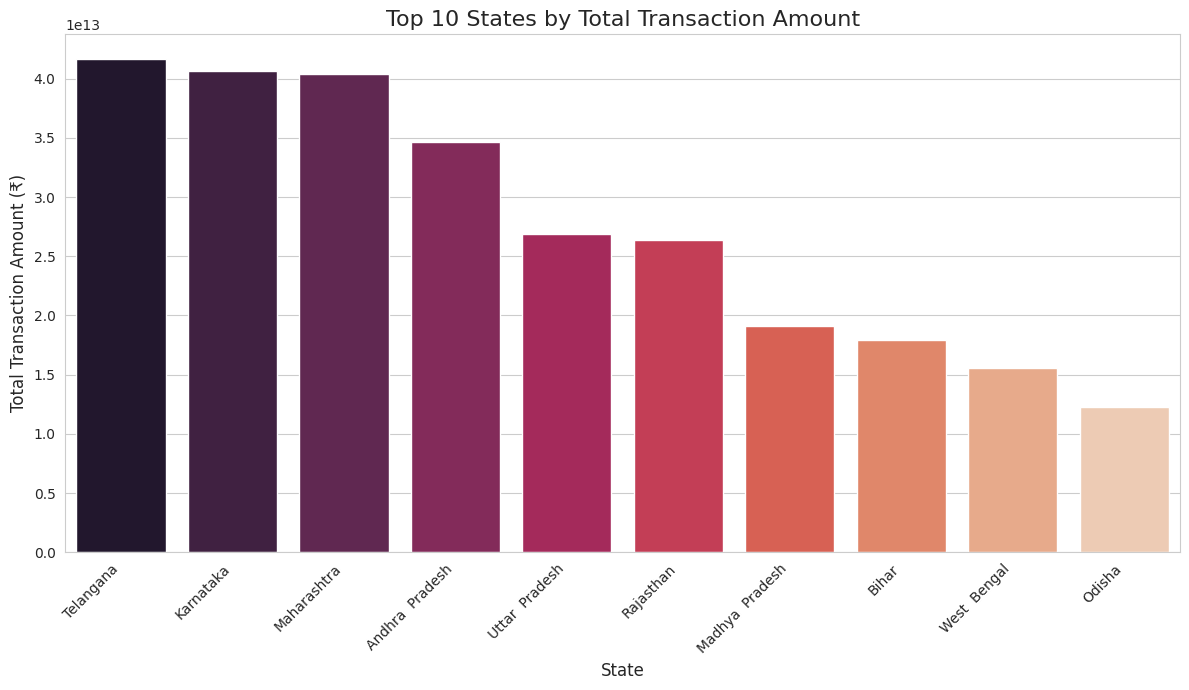

In [ ]:
# Top 10 States by Total Transaction Amount
plt.figure(figsize=(12, 7))
top_states_amount = df_agg_trans.groupby('State')['Transaction_Amount'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_states_amount.index, y=top_states_amount.values, palette='rocket')
plt.title('Top 10 States by Total Transaction Amount', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Transaction Amount (₹)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**Aggregated Users Visualizations**

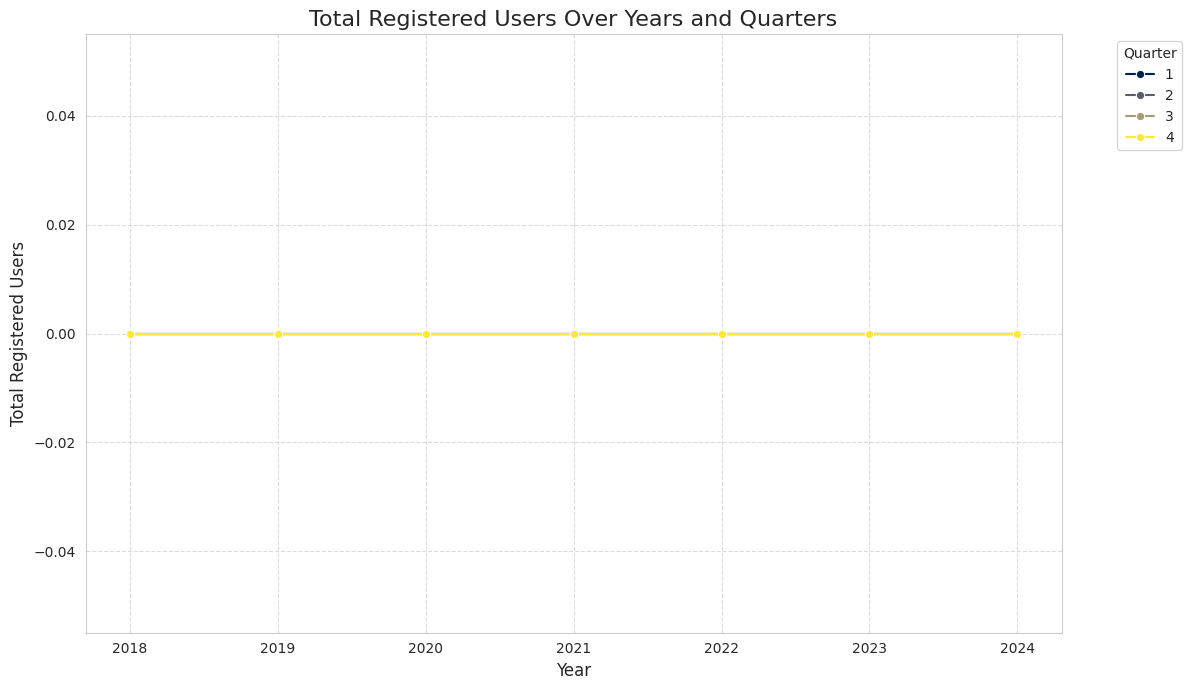

In [ ]:
# Total Registered Users Over Years and Quarters
plt.figure(figsize=(12, 7))
# Ensure 'Registered_Users' column exists before plotting
if 'Registered_Users' in df_agg_user.columns:
    agg_user_time = df_agg_user.groupby(['Year', 'Quarter'])['Registered_Users'].sum().reset_index()
    sns.lineplot(data=agg_user_time, x='Year', y='Registered_Users', hue='Quarter', marker='o', palette='cividis')
    plt.title('Total Registered Users Over Years and Quarters', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Total Registered Users', fontsize=12)
    plt.xticks(agg_user_time['Year'].unique(), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Registered Users plot: 'Registered_Users' column not found in df_agg_user.")


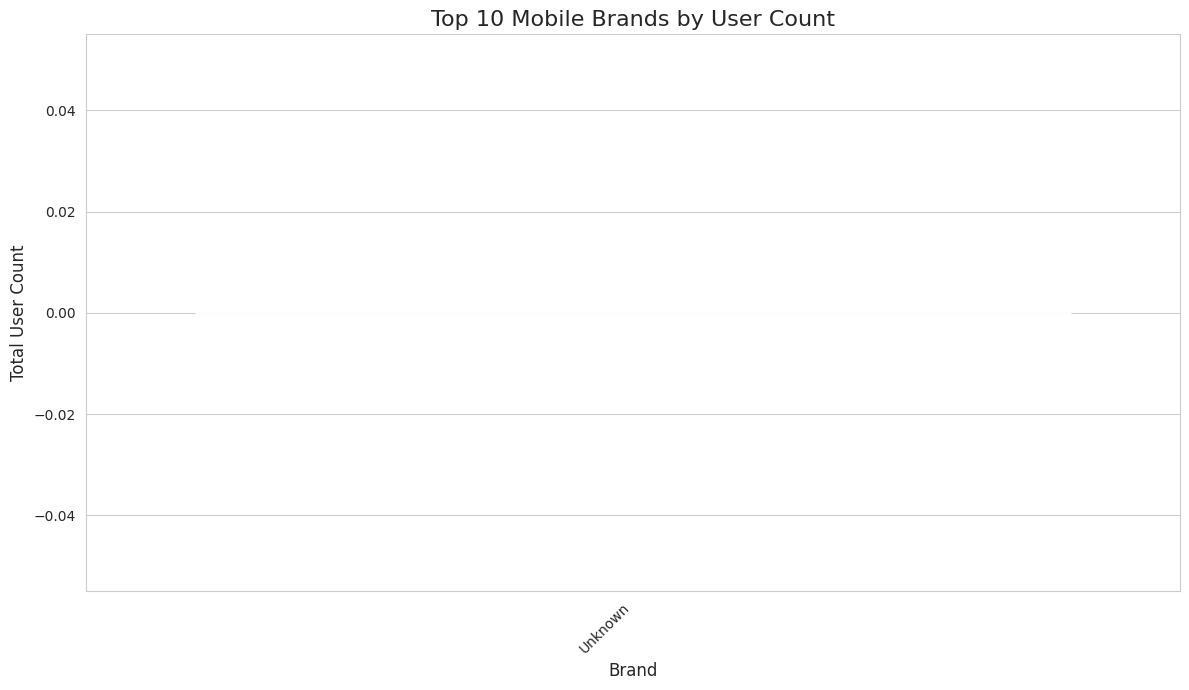

In [ ]:
# Top 10 Brands by User Count
plt.figure(figsize=(12, 7))
# Ensure 'Brand' and 'Count' columns exist before plotting
if 'Brand' in df_agg_user.columns and 'Count' in df_agg_user.columns:
    top_brands = df_agg_user.groupby('Brand')['Count'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=top_brands.index, y=top_brands.values, palette='mako')
    plt.title('Top 10 Mobile Brands by User Count', fontsize=16)
    plt.xlabel('Brand', fontsize=12)
    plt.ylabel('Total User Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Top Brands plot: 'Brand' or 'Count' column not found in df_agg_user.")


** Geo Visualization with Plotly (Aggregated Transactions by State)**

In [ ]:
# Aggregate data for plotting on map (e.g., total transaction amount per state)
# We use the cleaned df_agg_trans
state_wise_total_amount = df_agg_trans.groupby('State')['Transaction_Amount'].sum().reset_index()
state_wise_total_amount.rename(columns={'Transaction_Amount': 'Total_Amount'}, inplace=True)

In [ ]:
# --- Load Indian States GeoJSON ---
# This GeoJSON file provides the geographical boundaries for Indian states.
# It's crucial for Plotly to correctly render the choropleth map.
# Source: https://raw.githubusercontent.com/SubhrajyotiSen/Indian_States_Geojson/master/india_state_geo.json
geojson_url = "https://raw.githubusercontent.com/SubhrajyotiSen/Indian_States_Geojson/master/india_state_geo.json"

In [ ]:
state_name_mapping = {
    'Andaman And Nicobar Islands': 'Andaman & Nicobar Island',
    'Arunachal Pradesh': 'Arunanchal Pradesh',
    'Dadra And Nagar Haveli And Daman And Diu': 'Dadra & Nagar Haveli & Daman & Diu', # As per some older GeoJSONs
    'Jammu And Kashmir': 'Jammu & Kashmir',
    'Odisha': 'Orissa', # Older name
    'Puducherry': 'Pondicherry', # Older name
    'Telangana': 'Telangana',
    'Uttar Pradesh': 'Uttar Pradesh',
    'Uttarakhand': 'Uttarakhand',
    'West Bengal': 'West Bengal',
    'Andhra Pradesh': 'Andhra Pradesh',
    'Assam': 'Assam',
    'Bihar': 'Bihar',
    'Chandigarh': 'Chandigarh',
    'Chhattisgarh': 'Chhattisgarh',
    'Goa': 'Goa',
    'Gujarat': 'Gujarat',
    'Haryana': 'Haryana',
    'Himachal Pradesh': 'Himachal Pradesh',
    'Jharkhand': 'Jharkhand',
    'Karnataka': 'Karnataka',
    'Kerala': 'Kerala',
    'Lakshadweep': 'Lakshadweep',
    'Madhya Pradesh': 'Madhya Pradesh',
    'Maharashtra': 'Maharashtra',
    'Manipur': 'Manipur',
    'Meghalaya': 'Meghalaya',
    'Mizoram': 'Mizoram',
    'Nagaland': 'Nagaland',
    'Nct Of Delhi': 'NCT of Delhi', # Example of possible mismatch
    'Punjab': 'Punjab',
    'Rajasthan': 'Rajasthan',
    'Sikkim': 'Sikkim',
    'Tamil Nadu': 'Tamil Nadu',
    'Tripura': 'Tripura'
}

In [ ]:
#  Apply mapping to the DataFrame's State column
state_wise_total_amount['State_Mapped'] = state_wise_total_amount['State'].map(state_name_mapping).fillna(state_wise_total_amount['State'])

In [ ]:
# Create the choropleth map
fig = px.choropleth(
    state_wise_total_amount,
    geojson=geojson_url,
    locations='State_Mapped', # Column in DataFrame to match with GeoJSON
    featureidkey="properties.ST_NM", # Key in GeoJSON properties that holds the state name
    color='Total_Amount',
    hover_name='State', # Original state name for hover info
    color_continuous_scale="Viridis",
    title='Total Transaction Amount by State in India',
    labels={'Total_Amount': 'Total Amount (₹)'}
)

In [ ]:
# Customize map layout
fig.update_geos(
    fitbounds="locations", # Zoom to fit India
    visible=False, # Hide background map
    projection_scale=1 # Adjust zoom level if needed
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

print("Geo Visualization complete.")

Geo Visualization complete.


#Database Insertion and Retrieval (Using SQLite)


In [ ]:
# Create a SQLite database connection
# This will create a file named 'phonepe_pulse.db' in your Colab/Jupyter environment
db_name = 'phonepe_pulse.db'
conn = sqlite3.connect(db_name)
cursor = conn.cursor()
{db_name}

{'phonepe_pulse.db'}

In [ ]:

# Save cleaned DataFrames to SQLite tables
# Using if_exists='replace' will overwrite the table if it already exists
try:
    df_agg_trans.to_sql('aggregated_transactions', conn, if_exists='replace', index=False)
    print("df_agg_trans saved to 'aggregated_transactions' table.")

    # Only save if DataFrame is not empty
    if not df_agg_user.empty:
        df_agg_user.to_sql('aggregated_users', conn, if_exists='replace', index=False)
        print("df_agg_user saved to 'aggregated_users' table.")
    else:
        print("df_agg_user is empty. Skipping saving to database.")

    if not df_map_trans.empty:
        df_map_trans.to_sql('map_transactions', conn, if_exists='replace', index=False)
        print("df_map_trans saved to 'map_transactions' table.")
    else:
         print("df_map_trans is empty. Skipping saving to database.")

    if not df_top_trans.empty:
        df_top_trans.to_sql('top_transactions', conn, if_exists='replace', index=False)
        print("df_top_trans saved to 'top_transactions' table.")
    else:
        print("df_top_trans is empty. Skipping saving to database.")

except Exception as e:
    print(f"Error saving data to SQLite: {e}")


df_agg_trans saved to 'aggregated_transactions' table.
df_agg_user saved to 'aggregated_users' table.
df_map_trans is empty. Skipping saving to database.
df_top_trans saved to 'top_transactions' table.


In [ ]:
# Verify data retrieval from SQLite
print("\nVerifying data retrieval from SQLite...")

try:
    fetched_agg_trans = pd.read_sql('SELECT * FROM aggregated_transactions LIMIT 5', conn)
    print("\nFetched data from 'aggregated_transactions':")
    print(fetched_agg_trans)

    if not df_agg_user.empty:
        fetched_agg_user = pd.read_sql('SELECT * FROM aggregated_users LIMIT 5', conn)
        print("\nFetched data from 'aggregated_users':")
        print(fetched_agg_user)
    else:
        print("\nSkipping fetching from 'aggregated_users': DataFrame was empty.")

    if not df_map_trans.empty:
        fetched_map_trans = pd.read_sql('SELECT * FROM map_transactions LIMIT 5', conn)
        print("\nFetched data from 'map_transactions':")
        print(fetched_map_trans)
    else:
         print("\nSkipping fetching from 'map_transactions': DataFrame was empty.")

    if not df_top_trans.empty:
        fetched_top_trans = pd.read_sql('SELECT * FROM top_transactions LIMIT 5', conn)
        print("\nFetched data from 'top_transactions':")
        print(fetched_top_trans)
    else:
        print("\nSkipping fetching from 'top_transactions': DataFrame was empty.")

except Exception as e:
    print(f"Error fetching data from SQLite: {e}")


Verifying data retrieval from SQLite...

Fetched data from 'aggregated_transactions':
            State  Year  Quarter          Transaction_Type  Transaction_Count  \
0  Uttar  Pradesh  2022        4         Merchant Payments          439247166   
1  Uttar  Pradesh  2022        4     Peer-To-Peer Payments          317613698   
2  Uttar  Pradesh  2022        4  Recharge & Bill Payments           78025017   
3  Uttar  Pradesh  2022        4        Financial Services             418329   
4  Uttar  Pradesh  2022        4                    Others            1064861   

   Transaction_Amount  
0        2.967820e+11  
1        1.030346e+12  
2        4.815907e+10  
3        4.302129e+08  
4        6.619850e+08  

Fetched data from 'aggregated_users':
            State  Year  Quarter  Registered_Users  App_Opens    Brand  Count  \
0  Uttar  Pradesh  2022        4                 0          0  Unknown      0   
1  Uttar  Pradesh  2022        2                 0          0  Unknown      0   


In [ ]:
# Close the database connection
conn.close()
print("\nSQLite database connection closed.")
print("You have successfully extracted, cleaned, visualized, and stored the PhonePe Pulse data.")
